In [1]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import jax.nn as nn
import jax
import optax
import functools

import pydot
import numpy as np
from helpers import *

In [2]:
key = jax.random.PRNGKey(42)

# Sequences

In [3]:
# sequences (fixed)
a = jnp.array([0,0,0,0])
b = jnp.array([1,0,0,1])
c = jnp.array([0,1,1,0])

# ancestral sequences (???)
d = jnp.array([0,0,0,0]) # ? 
e = jnp.array([0,0,0,0]) # ?

In [4]:
# similarity matrix (fixed)
sm = jnp.array([[0,1],
               [1,0]])

In [5]:
seqs = jnp.array([a,b,c,d,e],dtype=np.float32)

In [6]:
# a-\
#   [d]---[e]
# b-/     /
#        /
# c-----/

# tree (???)
#              a,b,c,d,e
t = jnp.array([[0,0,0,1,0],  # a
              [0,0,0,1,0],  # b
              [0,0,0,0,1],  # c
              [0,0,0,0,1],  # d
              [0,0,0,0,1]]) # e

labels = {0:'a',1:'b',2:'c',3:'d',4:'e'}

t = t.at[-1,-1].set(1)

In [7]:
# t = generate_t(5)

In [8]:
t

DeviceArray([[0, 0, 0, 1, 0],
             [0, 0, 0, 1, 0],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1]], dtype=int32)

In [9]:
def compute_cost(sequences, tree, verbose = False):
#     print(type(sequences))
#     print(sequences)
    selection = jnp.matmul(tree,sequences)
    
    if(verbose==True):
        show_graph_with_labels(t,labels)
    
#     #method 1: needs integers
#     selection = selection.astype(int)
#     ans = sm[selection,sequences].sum()
    
    #method 2:
    ans = abs(selection - sequences).sum()
 
    return ans

In [10]:
seqs

DeviceArray([[0., 0., 0., 0.],
             [1., 0., 0., 1.],
             [0., 1., 1., 0.],
             [0., 0., 0., 0.],
             [0., 0., 0., 0.]], dtype=float32)

In [11]:
t

DeviceArray([[0, 0, 0, 1, 0],
             [0, 0, 0, 1, 0],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1]], dtype=int32)

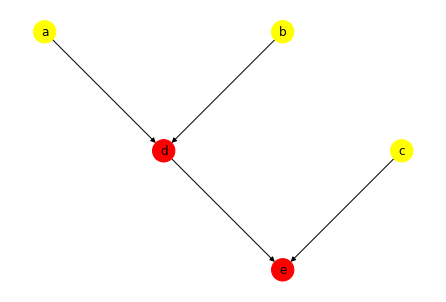

DeviceArray(4., dtype=float32)

In [12]:
compute_cost(seqs,t,1)

### Training

In [13]:
seqs.shape

(5, 4)

### initialize params

In [22]:
optimizer = optax.adam(0.01)

params = {'d':jnp.array([0,0,0.0,0.0]), 'e':jnp.array([0,0.0,0,0.0])}

#params = jax.random.uniform(key, (5,4))
opt_state = optimizer.init(params)

In [23]:
params

{'d': DeviceArray([0., 0., 0., 0.], dtype=float32),
 'e': DeviceArray([0., 0., 0., 0.], dtype=float32)}

In [24]:
def compute_loss(params, seqs_, t):
    seqs_ = seqs_.at[-2].set(seqs_[-2] + nn.sigmoid(params['d']))
    seqs_ = seqs_.at[-1].set(seqs_[-1] + nn.sigmoid(params['e']))
    
    loss  = compute_cost(seqs_,t)
    
    return loss

In [25]:
compute_loss(params, seqs, t)

DeviceArray(6., dtype=float32)

In [28]:
for _ in range(1000):
    grads = jax.grad(compute_loss)(params, seqs, t)
    
    if(_%100==0):
        print(compute_loss(params, seqs, t))
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)


4.1119375
4.0957513
4.0828023
4.0722885
4.0636635
4.05639
4.050297
4.0451074
4.0406795
4.0367727


## Retrieving the new sequences array

In [31]:
def combine_to_seq(params, seqs):
    seqs = seqs.at[-2].set(seqs[-2] + nn.sigmoid(params['d']))
    seqs = seqs.at[-1].set(seqs[-1] + nn.sigmoid(params['e']))
    
    return seqs

In [32]:
combine_to_seq(params, seqs)

DeviceArray([[0.        , 0.        , 0.        , 0.        ],
             [1.        , 0.        , 0.        , 1.        ],
             [0.        , 1.        , 1.        , 0.        ],
             [0.01260505, 0.00409208, 0.00409208, 0.01260505],
             [0.01260638, 0.5       , 0.5       , 0.01260638]],            dtype=float32)